In [1]:
import os
import pandas as pd
import re
import numpy as np

import umap
import matplotlib.pyplot as plt
import kmapper as km

# Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Images tools
import io
from PIL import Image
import base64

# Bokeh
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool, ColumnDataSource

# Data viz
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

# ML tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness

In [2]:
###############
## FUNCIONES ##
###############

# Limpiar y reemplazar comillas
def limpiar_y_reemplazar_comillas(texto):
    resultado = re.findall(r'\"(.*?)\"', texto)
    return resultado[0]

# Calcula Continuity (utilizando la fórmula adaptada)
def continuity(X_high, X_low, k):
    high_knn_indices = np.argsort(pairwise_distances(X_high), axis=1)[:, 1:k+1]
    low_knn_indices = np.argsort(pairwise_distances(X_low), axis=1)[:, 1:k+1]
    rank_matrix = np.zeros((X_high.shape[0], X_high.shape[0]))
    for i, indices in enumerate(high_knn_indices):
        rank_matrix[i, indices] = 1

    count = 0
    for i, indices in enumerate(low_knn_indices):
        count += np.sum(rank_matrix[i, indices] == 0)
    
    n_samples = X_high.shape[0]
    return 1 - (count / (n_samples * k))

In [3]:
os.chdir('C:/Users/alber/OneDrive/Desktop/MatCAD/4t Curso/TFG')

In [4]:
num_epochs = 100

### Primera capa convolucional

In [5]:
# Lista de pesos aplanados
all_weights_first_layer = pd.read_csv(f'modelos_entrenados_{num_epochs}_epoch/weights_first_layer_epoch_{num_epochs}.csv', header=None)

# Copia para no modificar la lista
all_weights_first_layer_mod = all_weights_first_layer.copy()

In [6]:
scale_min = -2.8
scale_max = 1.9

In [7]:
# Crear imágenes de los filtros
tooltip_s = []
tamaño_final = (60, 60)  # Nuevo tamaño de la imagen

for index in range(len(all_weights_first_layer_mod)):
    with io.BytesIO() as output:
        # Obtener los datos, recortar los valores y escalar a 0-255
        data = all_weights_first_layer.iloc[index].to_numpy().reshape(3, 3)
        data = np.clip(data, scale_min, scale_max)  # Recortar los valores fuera del rango
        data = ((data - scale_min) / (scale_max - scale_min) * 255).astype(np.uint8)  # Escalar a 0-255
        
        # Convertir los datos a imagen en escala de grises
        img = Image.fromarray(data, "L")
        
        # Ampliar la imagen al tamaño deseado con NEAREST que es el método de interpolación recomendado para ampliar píxeles
        img_ampliada = img.resize(tamaño_final, Image.NEAREST)
        
        # Guardar la imagen en un buffer
        img_ampliada.save(output, "PNG")
        contents = output.getvalue()
        
        # Codificar la imagen como base64
        img_encoded = base64.b64encode(contents)
        img_tag = f"""<img src="data:image/png;base64,{img_encoded.decode('utf-8')}">"""
        tooltip_s.append(img_tag)

# Creando una nueva columna en df_densos y asignándole los valores de tooltip_s
all_weights_first_layer_mod['Imagenes'] = tooltip_s

# Aplicar la función de limpieza
all_weights_first_layer_mod['Imagenes_new'] = all_weights_first_layer_mod['Imagenes'].apply(limpiar_y_reemplazar_comillas)


### Aplicando PCA

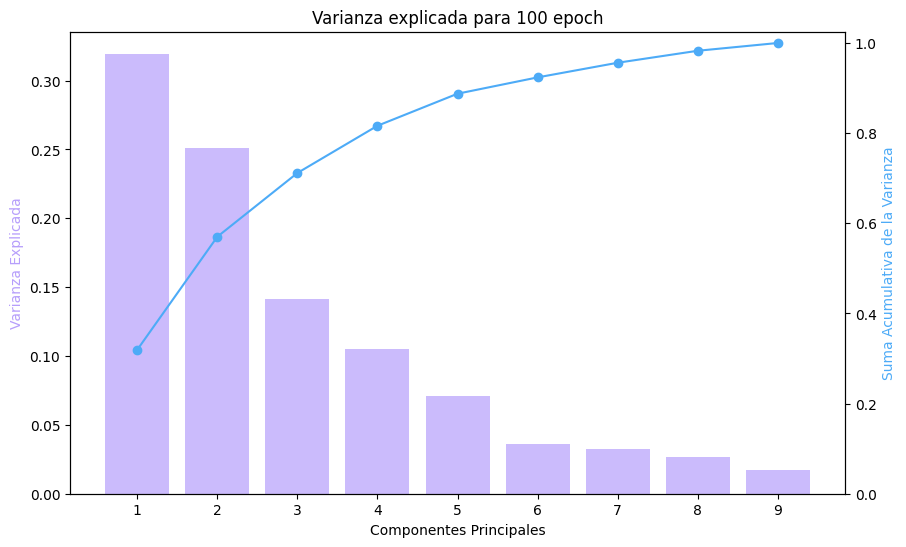

Varianza para 2 componentes: 0.5701899669126764
Varianza para 3 componentes: 0.7115864362337352


In [8]:
X_data = all_weights_first_layer_mod[list(range(9))]

# Aplicar PCA para reducción a un número de componentes que expliquen el 99% de la varianza
pca_varianza = PCA(n_components=0.99)
X_pca_varianza = pca_varianza.fit_transform(X_data)

# Varianza de la PCA
varianza_explicada_pca = pca_varianza.explained_variance_ratio_
suma_acumulativa_varianza = np.cumsum(varianza_explicada_pca)

# Crear el histograma
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(range(1, len(varianza_explicada_pca) + 1), varianza_explicada_pca, alpha=0.7, color='#B69EFB', label='Varianza explicada por componente')
ax1.set_xlabel('Componentes Principales')
ax1.set_ylabel('Varianza Explicada', color='#B69EFB')
ax1.set_title(f'Varianza explicada para {num_epochs} epoch')

# Crear el gráfico de suma acumulativa de la varianza en el mismo gráfico
ax2 = ax1.twinx()
ax2.plot(range(1, len(suma_acumulativa_varianza) + 1), suma_acumulativa_varianza, marker='o', color='#4DABF7', label='Suma acumulativa de la varianza')
ax2.set_ylabel('Suma Acumulativa de la Varianza', color='#4DABF7')
ax2.set_ylim(0, 1.025)  # Establecer el rango de la suma acumulativa de 0 a 1

# Mostrar los ticks
ax1.set_xticks(range(1, len(varianza_explicada_pca) + 1))

plt.show()

print("Varianza para 2 componentes:", sum(varianza_explicada_pca[:2]))
print("Varianza para 3 componentes:", sum(varianza_explicada_pca[:3]))

In [9]:
# Aplicar PCA para reducción a 2 dimensiones
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_data)

# Aplicar UMAP para reducción a 3 dimensiones
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_data)

# Los guardamos en un dataframe
df_X_pca_2d = pd.DataFrame(X_pca_2d)
df_X_pca_3d = pd.DataFrame(X_pca_3d)

# Guardamos la información en el dataframe principal
all_weights_first_layer_mod["pca_2d_0"] = df_X_pca_2d[0]
all_weights_first_layer_mod["pca_2d_1"] = df_X_pca_2d[1]
all_weights_first_layer_mod["pca_3d_0"] = df_X_pca_3d[0]
all_weights_first_layer_mod["pca_3d_1"] = df_X_pca_3d[1]
all_weights_first_layer_mod["pca_3d_2"] = df_X_pca_3d[2]

In [10]:
# Crear subgráficos: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter'}, {'type': 'scatter3d'}]],
    subplot_titles=('Visualización 2D', 'Visualización 3D')
)

# Añadir el gráfico 2D (ignorando la tercera dimensión)
fig.add_trace(
    go.Scatter(
        x=all_weights_first_layer_mod["pca_2d_0"],
        y=all_weights_first_layer_mod["pca_2d_1"],
        mode='markers',
        marker=dict(size=5, opacity=0.8, color="blue"),
        showlegend = False
    ),
    row=1, col=1
)

# Añadir el gráfico 3D
fig.add_trace(
    go.Scatter3d(
        x=all_weights_first_layer_mod["pca_3d_0"],
        y=all_weights_first_layer_mod["pca_3d_1"],
        z=all_weights_first_layer_mod["pca_3d_2"],
        mode='markers',
        marker=dict(size=5, opacity=0.8, color="blue"),
        showlegend = False
    ),
    row=1, col=2
)

# Actualizar layout para ajustar el tamaño del gráfico
fig.update_layout(height=600, width=1200, title_text=f"Comparación: 2D vs 3D PCA {num_epochs} epoch")
fig.update_xaxes(title_text="Componente 1", row=1, col=2)
fig.update_yaxes(title_text="Componente 2", row=1, col=2)

# Mostrando el gráfico
fig.show()

In [11]:
# Crear la figura
fig = go.Figure()

# Añadir el gráfico 2D (ignorando la tercera dimensión)
fig.add_trace(
    go.Scatter(
        x=all_weights_first_layer_mod["pca_2d_0"],
        y=all_weights_first_layer_mod["pca_2d_1"],
        mode='markers',
        marker=dict(size=5, opacity=0.8, color="blue"),
        showlegend=False  # Desactivar la leyenda
    )
)

rango_ejes = [-4, 4]

# Modificar los ejes del gráfico 2D
fig.update_xaxes(title_text="Componente 1", range=rango_ejes)
fig.update_yaxes(title_text="Componente 2", range=rango_ejes)

# Actualizar layout para ajustar el tamaño del gráfico
fig.update_layout(height=600, width=600, title_text=f"Visualización 2D PCA {num_epochs} epoch")

# Mostrar el gráfico
fig.show()

In [12]:
# Crear la figura
fig = go.Figure()

# Añadir el gráfico 3D
fig.add_trace(
    go.Scatter3d(
        x=all_weights_first_layer_mod["pca_3d_0"],
        y=all_weights_first_layer_mod["pca_3d_1"],
        z=all_weights_first_layer_mod["pca_3d_2"],
        mode='markers',
        marker=dict(size=2, opacity=0.8, color="blue"),
        showlegend=False  # Desactivar la leyenda
    )
)

# Establecer el rango de los ejes
rango_ejes = [-4, 4]

# Establecer el intervalo entre ticks
intervalo_ticks = 2

# Establecer parámetros de la cámara
r = 2  # Distancia de la cámara (zoom)
theta = - 3*  np.pi / 5  # Ángulo azimutal (45 grados)
phi = np.pi / 2.5  # Ángulo polar (30 grados)

# Calcular la posición de la cámara
eye_x = r * np.sin(phi) * np.cos(theta)
eye_y = r * np.sin(phi) * np.sin(theta)
eye_z = r * np.cos(phi)

# Configurar la cámara
camera = dict(
    eye=dict(x=eye_x, y=eye_y, z=eye_z),  # Posición de la cámara
    center=dict(x=0, y=0, z=-0.2),  # Centro del gráfico
    up=dict(x=0, y=0, z=1)  # Dirección "arriba" de la cámara
)

# Modificar los ejes del gráfico 3D y mantener proporciones 1:1
fig.update_scenes(
    aspectmode="cube",
    xaxis=dict(
        title_text='Componente 1',
        range=rango_ejes,
        dtick=intervalo_ticks  # Intervalo de ticks
    ),
    yaxis=dict(
        title_text='Componente 2',
        range=rango_ejes,
        dtick=intervalo_ticks  # Intervalo de ticks
    ),
    zaxis=dict(
        title_text='Componente 3',
        range=rango_ejes,
        dtick=intervalo_ticks  # Intervalo de ticks
    )
)

# Actualizar layout para ajustar el tamaño del gráfico y la cámara
fig.update_layout(
    height=600, 
    width=600, 
    title_text=f"Visualización 3D PCA {num_epochs} epoch",
    scene_camera=camera  # Aplicar configuración de la cámara
)

# Mostrar el gráfico
fig.show()


In [13]:
output_notebook()

# Añadir una columna que indique el grupo de cada 64 puntos
n = 64  # Número de puntos por grupo
all_weights_first_layer_mod['grupo'] = (np.arange(len(all_weights_first_layer_mod)) // n).astype(str)

# Ahora creamos el ColumnDataSource incluyendo la columna 'grupo'
datasource = ColumnDataSource(all_weights_first_layer_mod[["pca_2d_0", "pca_2d_1", "Imagenes_new", "grupo"]])

# Preparar el mapeador de colores. Aquí se usa un conjunto de colores de Bokeh,
# pero puedes personalizarlo con tus propios colores si lo deseas.
colores = [x for x in bokeh.palettes.d3['Category20'][20]]  # Ajustar según el número de grupos
mapeador_colores = factor_cmap('grupo', palette=colores, factors=all_weights_first_layer_mod['grupo'].unique())

# Crear el gráfico
plot_figure = figure(
    title=f'Proyección PCA 2D de los pesos de {num_epochs} epoch',
    width=800,
    height=800,
    tools=('pan, wheel_zoom, reset')
)

# Configurar el HoverTool para mostrar las imágenes
plot_figure.add_tools(HoverTool(tooltips="""
    <div>
        <div>
            <img src="@Imagenes_new" style="float: left; margin: 5px 5px 5px 5px" width="100" height="100"/>
        </div>
    </div>
    """))

# Dibujar los puntos, utilizando el mapeador de colores para definir su color
plot_figure.circle(
    'pca_2d_0', 
    'pca_2d_1', 
    source=datasource, 
    line_alpha=0.6, 
    fill_alpha=0.6, 
    size=10,  # Ajusta el tamaño según necesites
    color=mapeador_colores  # Usar el mapeador de colores
)

show(plot_figure)

Loading BokehJS ...

### Aplicando UMAP

In [14]:
#Normalizamos los datos para el UMAP
X_data = all_weights_first_layer_mod[list(range(9))]

In [15]:
# Aplicar UMAP para reducción a 2 dimensiones
umap_2d = umap.UMAP(n_components=2)
X_umap_2d = StandardScaler().fit_transform(umap_2d.fit_transform(X_data))

df_X_umap_2d = pd.DataFrame(X_umap_2d)

# Aplicar UMAP para reducción a 3 dimensiones
umap_3d = umap.UMAP(n_components=3)
X_umap_3d = StandardScaler().fit_transform(umap_3d.fit_transform(X_data))

df_X_umap_3d = pd.DataFrame(X_umap_3d)

all_weights_first_layer_mod["umap_2d_0"] = df_X_umap_2d[0]
all_weights_first_layer_mod["umap_2d_1"] = df_X_umap_2d[1]
all_weights_first_layer_mod["umap_3d_0"] = df_X_umap_3d[0]
all_weights_first_layer_mod["umap_3d_1"] = df_X_umap_3d[1]
all_weights_first_layer_mod["umap_3d_2"] = df_X_umap_3d[2]


In [16]:
# Calcula la matriz de distancias en el espacio UMAP
umap_distances_2d = pairwise_distances(X_umap_2d)
# Calcula Trustworthiness
trustworthiness_value_2d = trustworthiness(X_data, X_umap_2d, n_neighbors=5)
continuity_value_2d = continuity(X_data, X_umap_2d, k=5)

# Calcula la matriz de distancias en el espacio UMAP
umap_distances_3d = pairwise_distances(X_umap_3d)
# Calcula Trustworthiness
trustworthiness_value_3d = trustworthiness(X_data, X_umap_3d, n_neighbors=5)
continuity_value_3d = continuity(X_data, X_umap_3d, k=5)


print(f"Trustworthiness 2D: {trustworthiness_value_2d}")
print(f"Continuity 2D: {continuity_value_2d}")
print("######################")
print(f"Trustworthiness 3D: {trustworthiness_value_3d}")
print(f"Continuity 3D: {continuity_value_3d}")

Trustworthiness 2D: 0.9693186313291139
Continuity 2D: 0.4496875
######################
Trustworthiness 3D: 0.9779573773734177
Continuity 3D: 0.499375


In [17]:
# Crear subgráficos: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter'}, {'type': 'scatter3d'}]],
    subplot_titles=('Visualización 2D', 'Visualización 3D')
)

# Añadir el gráfico 2D (ignorando la tercera dimensión)
fig.add_trace(
    go.Scatter(
        x=all_weights_first_layer_mod["umap_2d_0"],
        y=all_weights_first_layer_mod["umap_2d_1"],
        mode='markers',
        marker=dict(size=5, opacity=0.8, color="blue"),
        showlegend = False  # Desactivar la leyenda para el segundo gráfico
    ),
    row=1, col=1
)

# Añadir el gráfico 3D
fig.add_trace(
    go.Scatter3d(
        x=all_weights_first_layer_mod["umap_3d_0"],
        y=all_weights_first_layer_mod["umap_3d_1"],
        z=all_weights_first_layer_mod["umap_3d_2"],
        mode='markers',
        marker=dict(size=5, opacity=0.8, color="blue"),
        showlegend = False  # Desactivar la leyenda para el segundo gráfico
    ),
    row=1, col=2
)

# Actualizar layout para ajustar el tamaño del gráfico
fig.update_layout(height=600, width=1200, title_text=f"Comparación: 2D vs 3D UMAP {num_epochs} epoch")
fig.update_xaxes(title_text="Componente 1", row=1, col=2)
fig.update_yaxes(title_text="Componente 2", row=1, col=2)

# Mostrando el gráfico
fig.show()


In [18]:
# Crear la figura
fig = go.Figure()

# Añadir el gráfico 2D (ignorando la tercera dimensión)
fig.add_trace(
    go.Scatter(
        x=all_weights_first_layer_mod["umap_2d_0"],
        y=all_weights_first_layer_mod["umap_2d_1"],
        mode='markers',
        marker=dict(size=5, opacity=0.8, color="blue"),
        showlegend=False  # Desactivar la leyenda
    )
)

rango_ejes = [-2.5, 2]

# Modificar los ejes del gráfico 2D
fig.update_xaxes(title_text="Componente 1", range=rango_ejes)
fig.update_yaxes(title_text="Componente 2", range=rango_ejes)

# Actualizar layout para ajustar el tamaño del gráfico
fig.update_layout(height=600, width=600, title_text=f"Visualización 2D UMAP {num_epochs} epoch")

# Mostrar el gráfico
fig.show()

In [19]:
# Crear la figura
fig = go.Figure()

# Añadir el gráfico 3D
fig.add_trace(
    go.Scatter3d(
        x=all_weights_first_layer_mod["umap_3d_0"],
        y=all_weights_first_layer_mod["umap_3d_1"],
        z=all_weights_first_layer_mod["umap_3d_2"],
        mode='markers',
        marker=dict(size=2, opacity=0.8, color="blue"),
        showlegend=False  # Desactivar la leyenda
    )
)

# Establecer el rango de los ejes
rango_ejes = [-3, 3]

# Establecer el intervalo entre ticks
intervalo_ticks = 2

# Establecer parámetros de la cámara
r = 2.1  # Distancia de la cámara (zoom)
theta = -0.7*np.pi / 5  # Ángulo azimutal (45 grados)
phi = 0.8*np.pi / 2.5  # Ángulo polar (30 grados)

# Calcular la posición de la cámara
eye_x = r * np.sin(phi) * np.cos(theta)
eye_y = r * np.sin(phi) * np.sin(theta)
eye_z = r * np.cos(phi)

# Configurar la cámara
camera = dict(
    eye=dict(x=eye_x, y=eye_y, z=eye_z),  # Posición de la cámara
    center=dict(x=0, y=0, z=-0.2),  # Centro del gráfico
    up=dict(x=0, y=0, z=1)  # Dirección "arriba" de la cámara
)

# Modificar los ejes del gráfico 3D y mantener proporciones 1:1
fig.update_scenes(
    aspectmode="cube",
    xaxis=dict(
        title_text='Componente 1',
        range=rango_ejes,
        dtick=intervalo_ticks  # Intervalo de ticks
    ),
    yaxis=dict(
        title_text='Componente 2',
        range=rango_ejes,
        dtick=intervalo_ticks  # Intervalo de ticks
    ),
    zaxis=dict(
        title_text='Componente 3',
        range=rango_ejes,
        dtick=intervalo_ticks  # Intervalo de ticks
    )
)

# Actualizar layout para ajustar el tamaño del gráfico y la cámara
fig.update_layout(
    height=600, 
    width=600, 
    title_text=f"Visualización 3D UMAP {num_epochs} epoch",
    scene_camera=camera  # Aplicar configuración de la cámara
)

# Mostrar el gráfico
fig.show()


In [20]:
output_notebook()

# Añadir una columna que indique el grupo de cada 64 puntos
n = 64  # Número de puntos por grupo
all_weights_first_layer_mod['grupo'] = (np.arange(len(all_weights_first_layer_mod)) // n).astype(str)

# Ahora creamos el ColumnDataSource incluyendo la columna 'grupo'
datasource = ColumnDataSource(all_weights_first_layer_mod[["umap_2d_0", "umap_2d_1", "Imagenes_new", "grupo"]])

# Preparar el mapeador de colores. Aquí se usa un conjunto de colores de Bokeh,
# pero puedes personalizarlo con tus propios colores si lo deseas.
colores = [x for x in bokeh.palettes.d3['Category20'][20]]  # Ajustar según el número de grupos
mapeador_colores = factor_cmap('grupo', palette=colores, factors=all_weights_first_layer_mod['grupo'].unique())

# Crear el gráfico
plot_figure = figure(
    title=f'Proyección UMAP 2D de los pesos de {num_epochs} epoch',
    width=800,
    height=800,
    tools=('pan, wheel_zoom, reset')
)

# Configurar el HoverTool para mostrar las imágenes
plot_figure.add_tools(HoverTool(tooltips="""
    <div>
        <div>
            <img src="@Imagenes_new" style="float: left; margin: 5px 5px 5px 5px" width="100" height="100"/>
        </div>
    </div>
    """))

# Dibujar los puntos, utilizando el mapeador de colores para definir su color
plot_figure.circle(
    'umap_2d_0', 
    'umap_2d_1', 
    source=datasource, 
    line_alpha=0.6, 
    fill_alpha=0.6, 
    size=10,  # Ajusta el tamaño según necesites
    color=mapeador_colores  # Usar el mapeador de colores
)

show(plot_figure)

Loading BokehJS ...

###  Comparacion de VietorisRipsPersistence

In [21]:
# RAW DATA
VR3D = VietorisRipsPersistence(homology_dimensions = (0,1,2), n_jobs = -1)
diagrams_data = VR3D.fit_transform([all_weights_first_layer])
#plot_diagram(diagrams_data[0])

In [22]:
# Crear una figura con dos subplots, asegurando que el aspecto de la cuadrícula sea cuadrado
fig = make_subplots(rows=1, cols=1, subplot_titles=[f"Modelos {num_epochs} epoch"], 
                    shared_yaxes=True, shared_xaxes=True)

# Definir un mapeo de colores para cada dimensión (cambia los colores como desees)
dimension_colors = {
    'H0': '#EF553B',
    'H1': '#00CC96',
    'H2': '#AB63FA'
}

# Generar el primer gráfico
fig1 = plot_diagram(diagrams_data[0])
for trace in fig1['data']:
    # Asignar un color basado en la etiqueta del 'trace'
    trace_name = trace.name
    if trace_name in dimension_colors:
        trace.marker.color = dimension_colors[trace_name]
    fig.add_trace(trace, row=1, col=1)

# Ajustar el tamaño de la figura para mantener el aspecto 1:1
fig.update_layout(
    width=550, 
    height=550,
    title_text="Diagramas de persistencia",
    showlegend=True
)

fig.update_xaxes(
    range=[-0.15,2.3],
)

fig.update_yaxes(
    range=[-0.15,2.4],
)

# Mostrar el gráfico
fig.show()


In [23]:
# UMAP Y PCA 2D
VR2D = VietorisRipsPersistence(homology_dimensions = (0,1), n_jobs = -1)
diagrams_pca2d = VR2D.fit_transform([all_weights_first_layer_mod[["pca_2d_0","pca_2d_1"]]])
diagrams_umap2d = VR2D.fit_transform([all_weights_first_layer_mod[["umap_2d_0","umap_2d_1"]]])

In [24]:
# UMAP Y PCA 3D
VR3D = VietorisRipsPersistence(homology_dimensions = (0,1,2), n_jobs = -1)
diagrams_pca3d = VR3D.fit_transform([all_weights_first_layer_mod[["pca_3d_0","pca_3d_1","pca_3d_2"]]])
diagrams_umap3d = VR3D.fit_transform([all_weights_first_layer_mod[["umap_3d_0","umap_3d_1","umap_3d_2"]]])

In [25]:
# Crear una figura con dos subplots, asegurando que el aspecto de la cuadrícula sea cuadrado
fig = make_subplots(rows=1, cols=2, subplot_titles=["PCA 2D", "UMAP 2D"], 
                    shared_yaxes=True, shared_xaxes=True)

# Definir un mapeo de colores para cada dimensión (cambia los colores como desees)
dimension_colors = {
    'H0': '#EF553B',
    'H1': '#00CC96'
}

# Generar el primer gráfico
fig1 = plot_diagram(diagrams_pca2d[0])
for trace in fig1['data']:
    # Asignar un color basado en la etiqueta del 'trace'
    trace_name = trace.name
    if trace_name in dimension_colors:
        trace.marker.color = dimension_colors[trace_name]
    fig.add_trace(trace, row=1, col=1)

# Generar el segundo gráfico con los mismos colores
fig2 = plot_diagram(diagrams_umap2d[0])
for trace in fig2['data']:
    trace_name = trace.name
    if trace_name in dimension_colors:
        trace.marker.color = dimension_colors[trace_name]
    trace.showlegend = False  # Desactivar la leyenda para el segundo gráfico
    fig.add_trace(trace, row=1, col=2)

# Ajustar el tamaño de la figura para mantener el aspecto 1:1
fig.update_layout(
    width=1100, 
    height=550,
    title_text=f"Comparación de Diagramas {num_epochs} epoch",
    showlegend=True
)

fig.update_xaxes(
    range=[-0.1,2.1],
)

fig.update_yaxes(
    range=[-0.1,2.1],
)

# Mostrar el gráfico
fig.show()


In [26]:
# Crear una figura con dos subplots, asegurando que el aspecto de la cuadrícula sea cuadrado
fig = make_subplots(rows=1, cols=2, subplot_titles=["PCA 3D", "UMAP 3D"], 
                    shared_yaxes=True, shared_xaxes=True)

# Definir un mapeo de colores para cada dimensión (cambia los colores como desees)
dimension_colors = {
    'H0': '#EF553B',
    'H1': '#00CC96',
    'H2': '#AB63FA'
}

# Generar el primer gráfico
fig1 = plot_diagram(diagrams_pca3d[0])
for trace in fig1['data']:
    # Asignar un color basado en la etiqueta del 'trace'
    trace_name = trace.name
    if trace_name in dimension_colors:
        trace.marker.color = dimension_colors[trace_name]
    fig.add_trace(trace, row=1, col=1)

# Generar el segundo gráfico con los mismos colores
fig2 = plot_diagram(diagrams_umap3d[0])
for trace in fig2['data']:
    trace_name = trace.name
    if trace_name in dimension_colors:
        trace.marker.color = dimension_colors[trace_name]
    trace.showlegend = False  # Desactivar la leyenda para el segundo gráfico
    fig.add_trace(trace, row=1, col=2)

# Ajustar el tamaño de la figura para mantener el aspecto 1:1
fig.update_layout(
    width=1100, 
    height=550,
    title_text=f"Comparación de Diagramas {num_epochs} epoch",
    showlegend=True
)

fig.update_xaxes(
    range=[-0.1,2.1],
)

fig.update_yaxes(
    range=[-0.1,2.1],
)

# Mostrar el gráfico
fig.show()


### Mapper

In [13]:
# Calcular dos componentes principales para usar como lentes
pca = PCA(n_components=3)
umap_data = umap.UMAP(n_components=3, random_state=33)

#lenses = all_weights_first_layer
#lenses = pca.fit_transform(all_weights_first_layer)
lenses = StandardScaler().fit_transform(umap_data.fit_transform(all_weights_first_layer))

array_tooltip_s = np.array(tooltip_s)

# Inicializa Mapper
mapper = km.KeplerMapper(verbose=2)

# Aquí, en lugar de usar pca_result_dense_layer, usamos pca_X_scaled directamente
# No aplicamos una segunda transformación, ya que pca_X_scaled ya es el resultado de PCA
graph = mapper.map(
    cover=km.Cover(n_cubes=2, perc_overlap=0.05),
    clusterer=AffinityPropagation(),
    lens = lenses
)

# Visualiza el grafo
# Asegúrate de ajustar path_html al lugar donde quieres guardar el archivo HTML de visualización
mapper.visualize(
    graph,
    title=f"UMAP3 Mapper {num_epochs} epoch",
    path_html=f'umap3_result_mapper_{num_epochs}_epoch.html',
    #color_values=X_scaled[:, 0],  # Usa la primera componente de PCA como color
    color_function_name="PCA Component 1",
    custom_tooltips=array_tooltip_s
)

print(f"Visualización de Mapper guardada en 'result_mapper_{num_epochs}_epoch.html'.")

c:\Users\alber\.conda\envs\alberto porfavor gracias\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



KeplerMapper(verbose=2)
Mapping on data shaped (640, 3) using lens shaped (640, 3)

Minimal points in hypercube before clustering: 2
Creating 8 hypercubes.
   > Found 4 clusters in hypercube 0.
   > Found 6 clusters in hypercube 1.
   > Found 4 clusters in hypercube 2.
   > Found 5 clusters in hypercube 3.
   > Found 7 clusters in hypercube 4.
   > Found 5 clusters in hypercube 5.
   > Found 16 clusters in hypercube 6.
   > Found 4 clusters in hypercube 7.

Created 15 edges and 51 nodes in 0:00:00.153997.


c:\Users\alber\.conda\envs\alberto porfavor gracias\lib\site-packages\kmapper\kmapper.py:866: UserWarning:

`color_function_name` was set -- however, no `color_values` were passed, so default color_values were computed based on row order, and the passed `color_function_name` will be set as their label. This may be unexpected.



Wrote visualization to: umap3_result_mapper_100_epoch.html
Visualización de Mapper guardada en 'result_mapper_100_epoch.html'.
